# Welcome to the hair type prediction notebook

***Disclaimer:*** This is no where near to my proposed project, however since my project relies on datasets i couldn't find on kaggle i decided to implement the same model architecture but with a CNN and a different but exciting dataset 

This notebook designs a Convulational Neural Network that predicts hair types from a dataset of around 1900 images and five classess namely; curly, dreadlocks, kinky, straight and Wavy. 

In [1]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


# Part 1: Image dataset handling and processing

In this part divided my data into three parts. Two already existing parts: Train and Test, And the third potion which is validation data. Validation is taken from training data

In [2]:
image_size = (200, 200)
batch_size = 32

train_directory = 'data/train'
test_directory = 'data/test'

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = train_datagen.flow_from_directory(train_directory, 
                                                  target_size = image_size, 
                                                  batch_size = batch_size, 
                                                  class_mode = 'categorical',
                                                  subset='training'
                                                  )

val_data = train_datagen.flow_from_directory(train_directory,
                                                       target_size = image_size,
                                                       batch_size = batch_size,
                                                       class_mode = 'categorical',
                                                       subset='validation'
                                                         )

test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(test_directory, target_size = image_size, batch_size = batch_size,class_mode = 'categorical')

Found 1329 images belonging to 5 classes.
Found 329 images belonging to 5 classes.
Found 329 images belonging to 5 classes.


# PART 2: Vanilla model

in this part i designed a vanilla model that has an input convulation layer that takes shape (200, 200, 3) because i did not use greyscale in the essence of catching something more with color

In [3]:
vanilla_model = Sequential()
vanilla_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
vanilla_model.add(layers.MaxPooling2D((2, 2)))

# Adding more hidden layers to the model to increase the complexity of the model
vanilla_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
vanilla_model.add(layers.MaxPooling2D((2, 2)))
vanilla_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
vanilla_model.add(layers.MaxPooling2D((2, 2)))
vanilla_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
vanilla_model.add(layers.MaxPooling2D((2, 2)))
vanilla_model.add(layers.Flatten())

# Finally adding a dense layer to the model
vanilla_model.add(layers.Dense(512, activation='relu'))

# A softmax layer for the output since this is a multi-class classification model
vanilla_model.add(layers.Dense(5, activation='softmax'))

# in this vanilla model we are using adam as the optimizer and categorical crossentropy as the loss function
vanilla_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = vanilla_model.fit(train_data, epochs = 20, validation_data = val_data)



c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 907ms/step - accuracy: 0.2227 - loss: 1.8124 - val_accuracy: 0.2523 - val_loss: 1.5537
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 904ms/step - accuracy: 0.3107 - loss: 1.5314 - val_accuracy: 0.4195 - val_loss: 1.4392
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 905ms/step - accuracy: 0.4135 - loss: 1.4226 - val_accuracy: 0.4650 - val_loss: 1.3030
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 928ms/step - accuracy: 0.5272 - loss: 1.1958 - val_accuracy: 0.4863 - val_loss: 1.2747
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 881ms/step - accuracy: 0.5524 - loss: 1.0937 - val_accuracy: 0.4924 - val_loss: 1.3269
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 898ms/step - accuracy: 0.6457 - loss: 0.9089 - val_accuracy: 0.5046 - val_loss: 1.2219
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 231s 6s/step - accuracy: 0.7317 - loss: 0.6757 - val_accuracy: 0.5653 - val_loss: 1.4545
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 848ms/step - accuracy: 0.8050 - loss: 0.5244 - val_accuracy: 0.5198 

In [11]:
loss, accuracy = vanilla_model.evaluate(test_data)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5629 - loss: 3.7125
Test accuracy : 0.5592705011367798
Test loss : 3.420478105545044


# PART 3: Regularized model

In the previous model we can see overfitting in the difference between the validation accuracy and training accuracy so in the next model i will add regularization techniques to solve the issue

In [8]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

regularized_model = Sequential()
regularized_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
regularized_model.add(layers.MaxPooling2D((2, 2)))
regularized_model.add(Dropout(0.3)) # Adding dropout to the model to prevent overfitting

# Adding more hidden layers to the model to increase the complexity of the model
regularized_model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
regularized_model.add(layers.MaxPooling2D((2, 2)))
regularized_model.add(Dropout(0.3))
regularized_model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
regularized_model.add(layers.MaxPooling2D((2, 2)))
regularized_model.add(Dropout(0.3))
regularized_model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
regularized_model.add(layers.MaxPooling2D((2, 2)))
regularized_model.add(Dropout(0.3))
regularized_model.add(layers.Flatten())

# Adding a dense layer to the model
regularized_model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
regularized_model.add(Dropout(0.3))
regularized_model.add(layers.Dense(5, activation='softmax')) 

# Adding early stopping to the model to prevent and track overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# in this regularized model we are using RMSprop as the optimizer different from the vanilla model
regularized_model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = regularized_model.fit(train_data, epochs = 20, validation_data= val_data, callbacks=[early_stopping])



c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 975ms/step - accuracy: 0.2493 - loss: 6.1906 - val_accuracy: 0.2280 - val_loss: 2.5795
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 929ms/step - accuracy: 0.2644 - loss: 2.4654 - val_accuracy: 0.2918 - val_loss: 2.2274
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 948ms/step - accuracy: 0.3714 - loss: 2.0825 - val_accuracy: 0.3647 - val_loss: 1.9249
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 933ms/step - accuracy: 0.4217 - loss: 1.8064 - val_accuracy: 0.2644 - val_loss: 1.7977
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 941ms/step - accuracy: 0.4395 - loss: 1.6549 - val_accuracy: 0.4012 - val_loss: 1.6284
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 483s 12s/step - accuracy: 0.4406 - loss: 1.5703 - val_accuracy: 0.3982 - val_loss: 1.5352
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 905ms/step - accuracy: 0.4695 - loss: 1.4606 - val_accuracy: 0.4833 - val_loss: 1.4629
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 921ms/step - accuracy: 0.5055 - loss: 1.3614 - val_accur

In [12]:
loss, accuracy = regularized_model.evaluate(test_data)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4328 - loss: 1.3938
Test accuracy : 0.45896655321121216
Test loss : 1.423917531967163


In [19]:
# Saving the models in an efficient way to be able to load them later
regularized_model.save('model2.keras')
vanilla_model.save('model1.keras')

In [20]:
#since .keras files are too large to upload, I will save the models in a pickle file
import pickle
with open('saved_models/model1.pkl', 'wb') as f:
    pickle.dump('model1.keras', f)

    
with open('saved_models/model2.pkl', 'wb') as f:
    pickle.dump('model2.keras', f)

# PART 4: Error Analysis and model intepratation

In this part we will examine the models further to see how they perform and what could be done to improve this model


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step

Confusion Matrix:
 [[17 13 18 20  9]
 [14  7  7 12  2]
 [14 26 25 25  8]
 [16 25 17 17  9]
 [ 4  2  6 10  6]]

Classification Report:
               precision    recall  f1-score   support

    Straight       0.26      0.22      0.24        77
        Wavy       0.10      0.17      0.12        42
       curly       0.34      0.26      0.29        98
  dreadlocks       0.20      0.20      0.20        84
       kinky       0.18      0.21      0.19        28

    accuracy                           0.22       329
   macro avg       0.22      0.21      0.21       329
weighted avg       0.24      0.22      0.23       329


Model Performance Metrics:
Accuracy: 0.2188
Precision: 0.2422
Recall: 0.2188
F1 Score: 0.2268


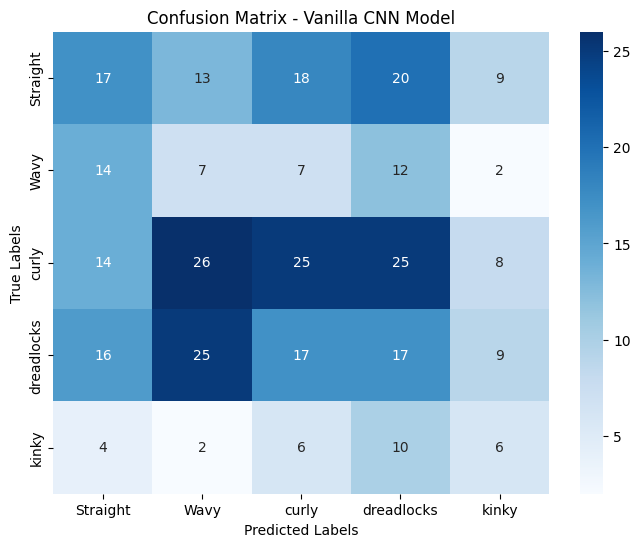

In [21]:

# making a prediction on the test data using the vanilla model
pred_prob = vanilla_model.predict(test_data) 
pred_labels = np.argmax(pred_prob, axis=1)  

# getting the true labels of the test data (the five classes we have) and comparing it with the predicted labels
true_labels = test_data.classes  

conf_matrix = confusion_matrix(true_labels, pred_labels) # getting the confusion matrix
print("\nConfusion Matrix:\n", conf_matrix)

class_names = test_data.class_indices  
print("\nClassification Report:\n", classification_report(true_labels, pred_labels, target_names=list(class_names.keys())))

# Calculating the performance metrics of the model using the true and predicted labels
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')  
recall = recall_score(true_labels, pred_labels, average='weighted')  
f1 = f1_score(true_labels, pred_labels, average='weighted') 

# Printing the performance metrics of the model
print(f"\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(class_names.keys()), 
            yticklabels=list(class_names.keys()))
plt.title('Confusion Matrix - Vanilla CNN Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step

Confusion Matrix:
 [[21 10 15 22  9]
 [11  5  3 15  8]
 [19  4 15 51  9]
 [23  8 17 28  8]
 [10  2  3 11  2]]

Classification Report:
               precision    recall  f1-score   support

    Straight       0.25      0.27      0.26        77
        Wavy       0.17      0.12      0.14        42
       curly       0.28      0.15      0.20        98
  dreadlocks       0.22      0.33      0.27        84
       kinky       0.06      0.07      0.06        28

    accuracy                           0.22       329
   macro avg       0.20      0.19      0.19       329
weighted avg       0.23      0.22      0.21       329


Model Performance Metrics:
Accuracy: 0.2158
Precision: 0.2258
Recall: 0.2158
F1 Score: 0.2113


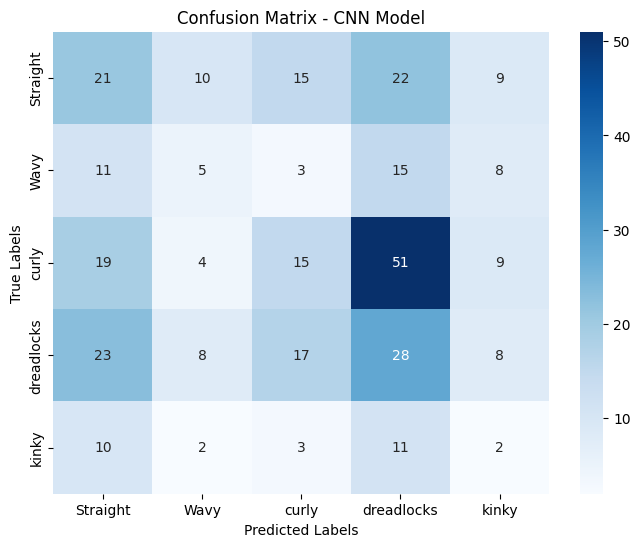

In [22]:
# making a prediction on the test data using the regularized model
r_pred_prob = regularized_model.predict(test_data) 
r_pred_labels = np.argmax(r_pred_prob, axis=1)  

# getting the true labels of the test data and comparing it with the predicted labels and then getting the confusion matrix
r_true_labels = test_data.classes  

conf_matrix = confusion_matrix(r_true_labels, r_pred_labels)
print("\nConfusion Matrix:\n", conf_matrix)

class_names = test_data.class_indices  
print("\nClassification Report:\n", classification_report(r_true_labels, r_pred_labels, target_names=list(class_names.keys())))

# Calculating the performance metrics of the model using the true and predicted labels
accuracy = accuracy_score(r_true_labels, r_pred_labels)
precision = precision_score(r_true_labels, r_pred_labels, average='weighted')  
recall = recall_score(r_true_labels, r_pred_labels, average='weighted')  
f1 = f1_score(r_true_labels, r_pred_labels, average='weighted') 

print(f"\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(class_names.keys()), 
            yticklabels=list(class_names.keys()))
plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Conclusion:

From the error analysis alot of observations and deductions can be made. The main observations are:

**Model Performance**:
Performance wise The vanilla model achieved a test accuracy of approximately 55.93%, while the regularized model achieved a test accuracy of approximately 45.90%. The vanilla model's loss was higher (3.55) compared to the regularized model's loss (1.39), indicating that the regularized model was better at minimizing the loss function. This means on the test data the vanilla model outperformed the regularized model. With regards to the loss the results show that the regularized model is better at minimizing the loss function and avoiding overfitting.

**Confusion Matrix**:
Both models struggled to accurately classify certain hair types, as evidenced by the confusion matrices. Misclassifications were common across all classes. The confusion matrices for both models show that the models often confused similar hair types, which suggests that the features extracted by the models were not sufficiently discriminative.

**Classification Report**:
The classification reports for both models indicate that precision, recall, and F1 scores were generally low across all classes. This suggests that the models had difficulty in correctly identifying the hair types. The regularized model showed slightly better precision and recall for some classes compared to the vanilla model, but overall performance metrics were still suboptimal.

# What can be done?

To increase the performance of this model to advance to further stages of development i think the following can be done

- **Data Immprovements**: On the step of data augmentation experimenting with different sizes and maybe other transformations can probably improve the model. I tried increasing image sizes but the model increased its training time and resources needed and that was a limiting factor
- **Model Architecture**: Experimenting with more layers or in case of the regularized models experimenting with other regularizers like L1 can probably improve the model
- **Parameter Tuning**: Fine-tuning hyperparameters such as learning rate, batch size, and regularization parameters could yield better results.

I tried experimenting with different epoch numbers, different batch sizes but due to the resource intensive nature of cnn there was latency and i decided to go with the optimal values. 




# Lastly?
While both models provided a baseline for hair type classification, there is significant room for improvement. I'm looking forward to learning new techniques to help in enhancing the model's ability to extract and learn more discriminative features, as well as addressing the challenges of overfitting and class imbalance in a more accurate way.